# SETUP

In [1]:
USE_GPU = True

In [2]:
!pip install --upgrade pip tensorflow keras jupyterlab-vim pydot &> pip.log
!apt-get install graphviz -y &> apt.log

## Libraries

In [3]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
from keras.models import load_model
import keras.backend as K

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.time_series_utils import splitTrainTestTimeSeries, reframePastFuture

# Configuration reader
from src.config_reader import ConfigurationReader

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# My custom libraries
from src.plot import plot_2_data

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1753606832.488443 2712543 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753606832.494583 2712543 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753606832.510167 2712543 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753606832.510199 2712543 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753606832.510201 2712543 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753606832.510202 2712543 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [4]:
confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data
print(conf)

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx",
            "target_start_date": "2022-01-01",
            "target_end_date": "2022-12-31"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.c

# MPAIR DATA ALL LOCATIONS

## Load dataset

* Every row has a tuple (i, j) which marks a "cell" in the Ho Chi Minh City grid map

| i/j | 0 | 1 | 2 | ... |
|-----|---|---|---|-----|
| 0   |   |   |   |     |
| 1   |   |   |   |     |
| 2   |   |   |   |     |
| ... |   |   |   |     |

* Every cell has its own geographical characteristics
* Every cell represent values of a specific date and specific location

### Raw data

In [5]:
df_mpair_raw = pd.read_csv(conf["dataset"]["mpair"]["merged_data_dir_all_locations"], index_col=None)
df_mpair_raw

,i,j,lat,lon,time,pm25_3km,tmp,rh,hpbl,wspd,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
0,0,3,11.149747,106.369103,2021-01-01,26.040001,25.114687,63.633778,567.478943,4.660580,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
1,0,3,11.149747,106.369103,2021-01-01,39.470001,24.043423,69.082085,485.584290,3.288929,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
2,0,3,11.149747,106.369103,2021-01-01,40.619999,25.058735,67.647362,403.936310,2.731468,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
3,0,3,11.149747,106.369103,2021-01-01,40.330002,25.554197,71.023094,704.476807,3.522596,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.555355,NaN,NaN
4,0,3,11.149747,106.369103,2021-01-01,50.009998,25.037054,74.029236,534.426575,3.223711,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713205,34,27,10.385233,106.918383,2022-08-06,19.874584,24.644707,76.055573,441.420624,2.561953,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
713206,34,27,10.385233,106.918383,2022-08-06,17.509365,25.071791,78.165489,403.261658,2.126233,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
713207,34,27,10.385233,106.918383,2022-08-06,18.428423,25.458431,79.421234,425.696411,1.909332,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,0.174487,NaN,NaN
713208,34,27,10.385233,106.918383,2022-08-06,12.645213,24.636055,76.198395,241.369736,2.530340,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN


In [6]:
df_mpair_raw.columns

Index(['i', 'j', 'lat', 'lon', 'time', 'pm25_3km', 'tmp', 'rh', 'hpbl', 'wspd',
       'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland',
       'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi', 'aod',
       'station', 'pm25'],
      dtype='object')

In [7]:
df_mpair_raw.isnull().sum()

i                         0
j                         0
lat                       0
lon                       0
time                      0
pm25_3km                  0
tmp                       0
rh                        0
hpbl                      0
wspd                      0
pop                       0
road_den_1km              0
prim_road_len_1km    708830
near_dist                 0
bareland                  0
builtup                   0
cropland                  0
grassland                 0
treecover                 0
water                     0
ndvi                 556260
aod                  429477
station              709195
pm25                 709195
dtype: int64

### Handle metadata

In [8]:
# Convert "time" columns to Pandas datetime
df_mpair_raw = df_mpair_raw.assign(time=pd.to_datetime(df_mpair_raw["time"]))

# Set "time" column as index
df_mpair_raw.set_index("time", inplace=True)

# Convert the -9999 to nan
df_mpair_raw[df_mpair_raw <= -9999] = np.nan

# Print
df_mpair_raw

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0,3,11.149747,106.369103,26.040001,25.114687,63.633778,567.478943,4.660580,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
2021-01-01,0,3,11.149747,106.369103,39.470001,24.043423,69.082085,485.584290,3.288929,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
2021-01-01,0,3,11.149747,106.369103,40.619999,25.058735,67.647362,403.936310,2.731468,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
2021-01-01,0,3,11.149747,106.369103,40.330002,25.554197,71.023094,704.476807,3.522596,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.555355,NaN,NaN
2021-01-01,0,3,11.149747,106.369103,50.009998,25.037054,74.029236,534.426575,3.223711,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-06,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-08-06,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-08-06,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,0.174487,NaN,NaN


## Preprocessing

In [9]:
df_mpair = copy.deepcopy(df_mpair_raw)

### Sort data by locations with stations, then locations without stations

In [10]:
locations_with_stations = sorted(list(df_mpair.loc[:, ["i", "j", "station"]].drop_duplicates().dropna().drop(columns=["station"]).itertuples(name=None, index=None)))
print(f"locations_with_stations = {locations_with_stations}")

all_locations = sorted(list(df_mpair.loc[:, ["i", "j"]].drop_duplicates().itertuples(name=None, index=None)))
print(f"all_locations = {all_locations}")

locations_without_stations = sorted(list(set(all_locations) - set(locations_with_stations)))
print(f"locations_without_stations = {locations_without_stations}")

sorted_locations = locations_with_stations + locations_without_stations
print(f"sorted_locations = {sorted_locations}")

locations_with_stations = [(12, 22), (15, 14), (15, 18), (16, 16), (16, 17), (17, 17), (18, 14)]
all_locations = [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 1

In [11]:
all_sorted_dfs = []
for (i, j) in sorted_locations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    # Fill station data
    df_mpair_current_ij.loc[:, "station"] = df_mpair_current_ij["station"].iloc[0]
    # Fill pm25 data
    df_mpair_current_ij.loc[:, "pm25"] = df_mpair_current_ij["pm25"].fillna(df_mpair_current_ij["pm25"].mean())
    all_sorted_dfs.append(df_mpair_current_ij)

df_mpair = pd.concat(all_sorted_dfs)
df_mpair

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-08-07,12,22,10.879919,106.803950,30.366625,25.749989,61.403439,533.919250,3.311250,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,46.732498,25.407879,59.282650,568.372009,2.977586,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,0.247559,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,45.280472,26.828142,61.058357,500.588928,1.905266,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,49.504631,27.283474,62.222889,603.052551,2.034556,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,60.881470,27.231569,63.081909,524.814148,2.716187,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,22.054035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-06,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-08-06,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-08-06,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,0.174487,NaN,NaN


### Define label, static features and dynamic features

In [12]:
print(df_mpair.columns)
mpair_label = ["pm25"]
mpair_stat_feats = ['lat', 'lon', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
mpair_dyn_feats = list(set(df_mpair.columns) - set(mpair_stat_feats) - set(mpair_label) - set(["i", "j", "station", "pm25_3km"]))

print(f"mpair_label = {mpair_label}\n\
mpair_stat_feats = {mpair_stat_feats}\n\
mpair_dyn_feats = {mpair_dyn_feats}\n")

Index(['i', 'j', 'lat', 'lon', 'pm25_3km', 'tmp', 'rh', 'hpbl', 'wspd', 'pop',
       'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup',
       'cropland', 'grassland', 'treecover', 'water', 'ndvi', 'aod', 'station',
       'pm25'],
      dtype='object')
mpair_label = ['pm25']
mpair_stat_feats = ['lat', 'lon', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
mpair_dyn_feats = ['hpbl', 'tmp', 'aod', 'wspd', 'rh']



### Fill missing values

In [13]:
null_stat = df_mpair.isnull().sum()
columns_to_fill = list(null_stat[null_stat > 0].keys())
stat_feats_to_fill = set(columns_to_fill) & set(mpair_stat_feats)
dyn_feats_to_fill = set(columns_to_fill) & set(mpair_dyn_feats)
print(f"columns_to_fill = {columns_to_fill}\n\
stat_feats_to_fill = {stat_feats_to_fill}\n\
dyn_feats_to_fill = {dyn_feats_to_fill}\n")

columns_to_fill = ['prim_road_len_1km', 'ndvi', 'aod', 'station', 'pm25']
stat_feats_to_fill = {'prim_road_len_1km', 'ndvi'}
dyn_feats_to_fill = {'aod'}



In [14]:
all_filled_dfs = []
for (i, j) in sorted_locations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]

    for feat in stat_feats_to_fill:
        df_mpair_current_ij.loc[:, feat] = df_mpair_current_ij[feat].fillna(value=0)
    for feat in dyn_feats_to_fill:
        df_mpair_current_ij.loc[:, feat] = df_mpair_current_ij[feat].replace([np.inf, -np.inf], np.nan)
        df_mpair_current_ij.loc[:, feat] = df_mpair_current_ij[feat].fillna(df_mpair_current_ij[feat].mean())

    all_filled_dfs.append(df_mpair_current_ij)

df_mpair = pd.concat(all_filled_dfs)
df_mpair

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-08-07,12,22,10.879919,106.803950,30.366625,25.749989,61.403439,533.919250,3.311250,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.639324,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,46.732498,25.407879,59.282650,568.372009,2.977586,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.247559,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,45.280472,26.828142,61.058357,500.588928,1.905266,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.639324,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,49.504631,27.283474,62.222889,603.052551,2.034556,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.639324,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,60.881470,27.231569,63.081909,524.814148,2.716187,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.639324,211.0,22.054035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-06,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056,NaN,NaN
2022-08-06,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056,NaN,NaN
2022-08-06,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.174487,NaN,NaN


### Split train/test/inference

In [15]:
inference_split_index = len(df_mpair.dropna(subset=["station"]))
df_mpair_train_val_test, df_mpair_inference = df_mpair[:inference_split_index], df_mpair[inference_split_index:]
df_mpair_train_val_test

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-08-07,12,22,10.879919,106.803950,30.366625,25.749989,61.403439,533.919250,3.311250,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.639324,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,46.732498,25.407879,59.282650,568.372009,2.977586,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.247559,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,45.280472,26.828142,61.058357,500.588928,1.905266,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.639324,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,49.504631,27.283474,62.222889,603.052551,2.034556,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.639324,211.0,22.054035
2021-08-07,12,22,10.879919,106.803950,60.881470,27.231569,63.081909,524.814148,2.716187,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.639324,211.0,22.054035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,18,14,10.745004,106.620857,31.512344,25.295406,66.642159,484.068359,1.859084,45417.710,...,5573.831706,911973.882028,2465.050483,14041.052167,57668.133163,8249.960386,2437.714788,0.835369,212.0,18.843761
2021-11-15,18,14,10.745004,106.620857,22.765150,26.981958,59.168281,624.954895,2.308777,45417.710,...,5573.831706,911973.882028,2465.050483,14041.052167,57668.133163,8249.960386,2437.714788,0.723000,212.0,18.843761
2021-11-15,18,14,10.745004,106.620857,28.393860,26.910824,59.916964,638.658203,2.330085,45417.710,...,5573.831706,911973.882028,2465.050483,14041.052167,57668.133163,8249.960386,2437.714788,0.194074,212.0,18.843761


In [16]:
df_mpair_inference

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0,3,11.149747,106.369103,26.040001,25.114687,63.633778,567.478943,4.660580,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883,NaN,NaN
2021-01-01,0,3,11.149747,106.369103,39.470001,24.043423,69.082085,485.584290,3.288929,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883,NaN,NaN
2021-01-01,0,3,11.149747,106.369103,40.619999,25.058735,67.647362,403.936310,2.731468,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883,NaN,NaN
2021-01-01,0,3,11.149747,106.369103,40.330002,25.554197,71.023094,704.476807,3.522596,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.555355,NaN,NaN
2021-01-01,0,3,11.149747,106.369103,50.009998,25.037054,74.029236,534.426575,3.223711,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-06,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056,NaN,NaN
2022-08-06,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056,NaN,NaN
2022-08-06,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.174487,NaN,NaN


In [17]:
# Split the total data into train/val/test and inference
X_train_val_test = df_mpair_train_val_test.drop(columns=["pm25_3km", "station", "pm25", "i", "j"])
y_train_val_test = pd.DataFrame(df_mpair_train_val_test["pm25"])

# Split the train/val/test data into train/val and test
test_percentage = 0.2
train_test_split_index = round(len(X_train_val_test) * (1 - test_percentage))
X_train_val = X_train_val_test[:train_test_split_index]
y_train_val = y_train_val_test[:train_test_split_index]
X_test = X_train_val_test[train_test_split_index:]
y_test = y_train_val_test[train_test_split_index:]

# Split the train/val into train and val
val_percentage = 0.2
train_val_split_index = round(len(X_train_val) * (1 - val_percentage))
X_train = X_train_val[:train_val_split_index]
y_train = y_train_val[:train_val_split_index]
X_val = X_train_val[train_val_split_index:]
y_val = y_train_val[train_val_split_index:]

# Inference data
X_inference = df_mpair_inference.drop(columns=["pm25_3km", "station", "pm25", "i", "j"])

# Print shape
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}\n\
X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

X_train.shape = (3270, 18), y_train.shape = (3270, 1)
X_test.shape = (1022, 18), y_test.shape = (1022, 1)


### Extract metadata columns

In [18]:
X_inference_ij_columns = df_mpair_inference.loc[:, ["i", "j"]]
X_inference_ij_columns

,i,j
time,,
2021-01-01,0,3
2021-01-01,0,3
2021-01-01,0,3
2021-01-01,0,3
2021-01-01,0,3
...,...,...
2022-08-06,34,27
2022-08-06,34,27
2022-08-06,34,27


### Scale data

In [19]:
mpair_Xtrain_scaler = MinMaxScaler()
X_train_scaled = mpair_Xtrain_scaler.fit_transform(X_train)
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,lat,lon,tmp,rh,hpbl,wspd,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,1.0,1.000,0.290460,0.299178,0.334582,0.462968,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.189582
1,1.0,1.000,0.258031,0.248661,0.359716,0.398351,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.058140
2,1.0,1.000,0.392658,0.290958,0.310267,0.190687,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.189582
3,1.0,1.000,0.435819,0.318697,0.385016,0.215725,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.189582
4,1.0,1.000,0.430899,0.339159,0.327940,0.347729,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.189582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,0.0,0.375,0.425930,0.447946,0.281480,0.257233,0.915791,0.79283,1.0,0.250325,0.000000,0.88279,0.000000,0.0,0.163994,0.249630,0.709483,0.194161
3266,0.0,0.375,0.422952,0.321101,0.418811,0.624682,0.915791,0.79283,1.0,0.250325,0.000000,0.88279,0.000000,0.0,0.163994,0.249630,0.709483,0.150867
3267,0.0,0.375,0.409944,0.512338,0.326514,0.276753,0.915791,0.79283,1.0,0.250325,0.000000,0.88279,0.000000,0.0,0.163994,0.249630,0.709483,0.194161
3268,0.0,0.375,0.494159,0.588618,0.336141,0.324925,0.915791,0.79283,1.0,0.250325,0.000000,0.88279,0.000000,0.0,0.163994,0.249630,0.709483,0.194161


In [20]:
mpair_ytrain_scaler = MinMaxScaler()
y_train_scaled = mpair_ytrain_scaler.fit_transform(y_train)
pd.DataFrame(y_train_scaled, columns=y_train.columns)

,pm25
0,0.199600
1,0.199600
2,0.199600
3,0.199600
4,0.199600
...,...
3265,0.509158
3266,0.249451
3267,0.246389
3268,0.377008


In [21]:
mpair_Xval_scaler = MinMaxScaler()
X_val_scaled = mpair_Xval_scaler.fit_transform(X_val)
pd.DataFrame(X_val_scaled, columns=X_val.columns)

,lat,lon,tmp,rh,hpbl,wspd,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,1.0,0.0,0.572139,0.567860,0.384497,0.142883,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192266
1,1.0,0.0,0.503495,0.244724,0.478411,0.550711,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.081846
2,1.0,0.0,0.362105,0.268160,0.392539,0.756533,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192266
3,1.0,0.0,0.369632,0.337467,0.301567,0.323125,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192266
4,1.0,0.0,0.498835,0.526786,0.361229,0.280808,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,0.0,0.0,0.321299,0.481278,0.486433,0.428915,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.174430
814,0.0,0.0,0.356310,0.476959,0.363497,0.373068,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.174430
815,0.0,0.0,0.491640,0.470420,0.408990,0.169505,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.174430
816,0.0,0.0,0.570821,0.360563,0.381331,0.586358,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.162002


In [22]:
mpair_yval_scaler = MinMaxScaler()
y_val_scaled = mpair_yval_scaler.fit_transform(y_val)
pd.DataFrame(y_val_scaled, columns=y_val.columns)

,pm25
0,0.498014
1,0.415821
2,0.273536
3,0.273536
4,0.369334
...,...
813,0.123260
814,0.123260
815,0.123260
816,0.159876


In [23]:
mpair_Xtest_scaler = MinMaxScaler()
X_test_scaled = mpair_Xtest_scaler.fit_transform(X_test)
pd.DataFrame(X_test_scaled, columns=X_test.columns)

,lat,lon,tmp,rh,hpbl,wspd,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,1.0,1.0,0.420125,0.653496,0.517543,0.422042,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.248588
1,1.0,1.0,0.350335,0.620364,0.507201,0.419709,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.342893
2,1.0,1.0,0.373492,0.621068,0.522464,0.367865,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.186308
3,1.0,1.0,0.449077,0.565920,0.395077,0.259710,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.186308
4,1.0,1.0,0.436151,0.590671,0.359889,0.374984,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.157566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,0.0,0.0,0.189807,0.400052,0.334777,0.154045,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.273820
1018,0.0,0.0,0.383213,0.230622,0.450426,0.242390,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.232350
1019,0.0,0.0,0.375056,0.247595,0.461675,0.246576,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.037150
1020,0.0,0.0,0.305402,0.179661,0.318825,0.610271,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.273820


In [24]:
mpair_ytest_scaler = MinMaxScaler()
y_test_scaled = mpair_ytest_scaler.fit_transform(y_test)
pd.DataFrame(y_test_scaled, columns=y_test.columns)

,pm25
0,0.095349
1,0.193693
2,0.259141
3,0.216441
4,0.300988
...,...
1017,0.357867
1018,0.357867
1019,0.357867
1020,0.357867


In [25]:
mpair_Xinference_scaler = MinMaxScaler()
X_inference_scaled = mpair_Xinference_scaler.fit_transform(X_inference)
pd.DataFrame(X_inference_scaled, columns=X_inference.columns)

,lat,lon,tmp,rh,hpbl,wspd,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,1.0,0.000000,0.377580,0.308914,0.354281,0.477011,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.112335
1,1.0,0.000000,0.295472,0.420709,0.301440,0.318837,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.112335
2,1.0,0.000000,0.373292,0.391269,0.248758,0.254553,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.112335
3,1.0,0.000000,0.411267,0.460537,0.442676,0.345783,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.109521
4,1.0,0.000000,0.371630,0.522220,0.332955,0.311317,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.112335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708095,0.0,0.857143,0.341558,0.563799,0.272944,0.235005,0.020028,0.071699,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.088991
708096,0.0,0.857143,0.374293,0.607092,0.248323,0.184759,0.020028,0.071699,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.088991
708097,0.0,0.857143,0.403927,0.632859,0.262799,0.159747,0.020028,0.071699,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.040508
708098,0.0,0.857143,0.340895,0.566729,0.143866,0.231359,0.020028,0.071699,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.088991


## LSTM prediction other locations

### Evaluation board

In [26]:
evaluation_board = {'dim_reduction_method': [],
                    'dim_after_reduction': [],
                    'prediction_method':[],
                    'mae (test data)': [],
                    'mse (test data)': [],
                    'r2 (test data)': []}

### Common functions

In [27]:
def reframe_past_future(sequence_X, sequence_y=None, n_past=1, n_future=1):
    ret_X, ret_y = list(), list()
    target_sequence = np.hstack((sequence_X, sequence_y)) if sequence_y is not None else sequence_X
    for window_start in range(len(target_sequence)):
        # find the end of this pattern
        past_end = window_start + n_past
        future_end = past_end + n_future

        # check if we are beyond the dataset
        if future_end > len(target_sequence):
            break
        # Append to result
        ret_X.append(target_sequence[window_start:past_end, :-1] if sequence_y is not None else target_sequence[window_start:past_end, :])
        ret_y.append(target_sequence[past_end:future_end, -1] if sequence_y is not None else target_sequence[past_end:future_end, :])

    return np.array(ret_X), np.array(ret_y)

# Define lstm model
def getLSTMmodel(n_past,n_future, n_features):
    model = Sequential()
    encoder_input = Input(shape=(n_past, n_features))
    encoder_lstm, state_h, state_c = LSTM(100, activation="relu", return_state=True)(encoder_input)
    decoder_input = RepeatVector(n_future)(encoder_lstm)
    decoder_lstm = LSTM(100, activation="relu", return_sequences=True)(decoder_input, initial_state = [state_h, state_c])
    decoder_dense_1 = TimeDistributed(Dense(100, activation="relu"))(decoder_lstm)
    decoder_dense_2 = TimeDistributed(Dense(1))(decoder_dense_1)
    model = Model(encoder_input, decoder_dense_2)
    #model.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.001))
    model.compile(loss=Huber(delta=1.0), optimizer=Adam(learning_rate=1e-3))
    return model

# LSTM Prediction
def predictLSTM(X_train, y_train, X_val, y_val, X_test, y_test, X_inference):
    # Define metadata
    n_past = conf["prediction"]["n_past"]
    n_future = conf["prediction"]["n_future"]
    
    # Reframe train data
    print(f"X_train.shape = {X_train.shape}\ny_train.shape = {y_train.shape}")
    X_train_reframed, y_train_reframed = reframe_past_future(X_train, y_train, n_past, n_future)
    print(f"X_train_reframed.shape = {X_train_reframed.shape}\ny_train_reframed.shape = {y_train_reframed.shape}")
    
    # Reframe validation data
    print(f"X_val.shape = {X_val.shape}\ny_val.shape = {y_val.shape}")
    X_val_reframed, y_val_reframed = reframe_past_future(X_val, y_val, n_past, n_future)
    print(f"X_val_reframed.shape = {X_val_reframed.shape}\ny_val_reframed.shape = {y_val_reframed.shape}")
    
    # Pad and reframe test data
    print(f"X_test.shape = {X_test.shape}\ny_test.shape = {y_test.shape}")
    X_test_padded = np.vstack((np.tile(X_test[0], (n_past, 1)), X_test))
    y_test_padded = np.vstack((np.tile(y_test[0], (n_past, 1)), y_test))
    print(f"X_test_padded.shape = {X_test_padded.shape}\ny_test_padded.shape = {y_test_padded.shape}")
    X_test_reframed, y_test_reframed = reframe_past_future(X_test_padded, y_test_padded, n_past, n_future)
    print(f"X_test_reframed.shape = {X_test_reframed.shape}\ny_test_reframed.shape = {y_test_reframed.shape}")

    # Pad and reframe inference data
    print(f"X_inference.shape = {X_inference.shape}")
    X_inference_padded = np.vstack((np.tile(X_inference[0], (n_past, 1)), X_inference))
    print(f"X_inference_padded.shape = {X_inference_padded.shape}")
    X_inference_reframed, _ = reframe_past_future(X_inference_padded, n_past=n_past, n_future=n_future)
    print(f"X_inference_refamed.shape = {X_inference_reframed.shape}")
    
    # Define callbacks
    checkpoint = ModelCheckpoint(filepath=f'{conf["workspace"]["model_checkpoints_dir"]}/lstm_prediction_mpair.keras', save_best_only=True)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        min_delta=0.001
    )
    
    # Fit model
    n_features = X_train_reframed.shape[-1]
    model = getLSTMmodel(n_past, n_future, n_features)
    model.fit(X_train_reframed, y_train_reframed,
            epochs=conf["prediction"]["epochs"],
            batch_size=conf["prediction"]["batch_size"],
            verbose=1,
            validation_data=(X_val_reframed, y_val_reframed),
            #callbacks=[checkpoint, early_stopping],
            callbacks=[checkpoint],
            shuffle=False)
    
    # Evaluation
    y_predicted = model.predict(X_test_reframed, verbose=1)
    inverted_y_predicted = mpair_ytest_scaler.inverse_transform(y_predicted[:, 0, :]) # Only applicable when n_future = 1
    inverted_y_predicted = inverted_y_predicted.reshape(-1, 1)
    inverted_y_test = mpair_ytest_scaler.inverse_transform(y_test)
    print(f"inverted_y_predicted.shape = {inverted_y_predicted.shape}")
    mae = mean_absolute_error(inverted_y_test, inverted_y_predicted)
    mse = mean_squared_error(inverted_y_test, inverted_y_predicted)
    r2 = r2_score(inverted_y_test, inverted_y_predicted)
    print(f"mae = {mae}")
    print(f"mse = {mse}")
    print(f"r2 = {r2}")
    plot_2_data(data1=inverted_y_predicted,
            data2=inverted_y_test,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

    # Inference
    y_inference = model.predict(X_inference_reframed, verbose=1)
    inverted_y_inference = mpair_ytest_scaler.inverse_transform(y_inference[:, 0, :]) # Only applicable when n_future = 1
    df_inference = pd.DataFrame(inverted_y_inference, index=X_inference_ij_columns.index, columns=["pm25"])
    df_inference = pd.concat([df_inference, X_inference_ij_columns], axis=1)
    print(f"df_inference.shape = {df_inference.shape}")
    return df_inference, mae, mse, r2

### Prediction no encoder

#### LSTM prediction

X_train.shape = (3270, 18)
y_train.shape = (3270, 1)
X_train_reframed.shape = (3263, 7, 18)
y_train_reframed.shape = (3263, 1)
X_val.shape = (818, 18)
y_val.shape = (818, 1)
X_val_reframed.shape = (811, 7, 18)
y_val_reframed.shape = (811, 1)
X_test.shape = (1022, 18)
y_test.shape = (1022, 1)
X_test_padded.shape = (1029, 18)
y_test_padded.shape = (1029, 1)
X_test_reframed.shape = (1022, 7, 18)
y_test_reframed.shape = (1022, 1)
X_inference.shape = (708100, 18)
X_inference_padded.shape = (708107, 18)
X_inference_refamed.shape = (708100, 7, 18)


I0000 00:00:1753606846.328180 2712543 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 818 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0


Epoch 1/200


I0000 00:00:1753606849.765613 2712700 service.cc:152] XLA service 0x776aa4004230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753606849.765641 2712700 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1753606850.423288 2712700 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753606851.260788 2712700 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0063 - val_loss: 0.0185
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0356
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0176
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0153
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0078
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0109 - val_loss: 0.0166
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0142
Epoch 8/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0125
Epoch 9/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0130
Epoch 10/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023 - val_loss: 0.0130
Epoch 11/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 12/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - va

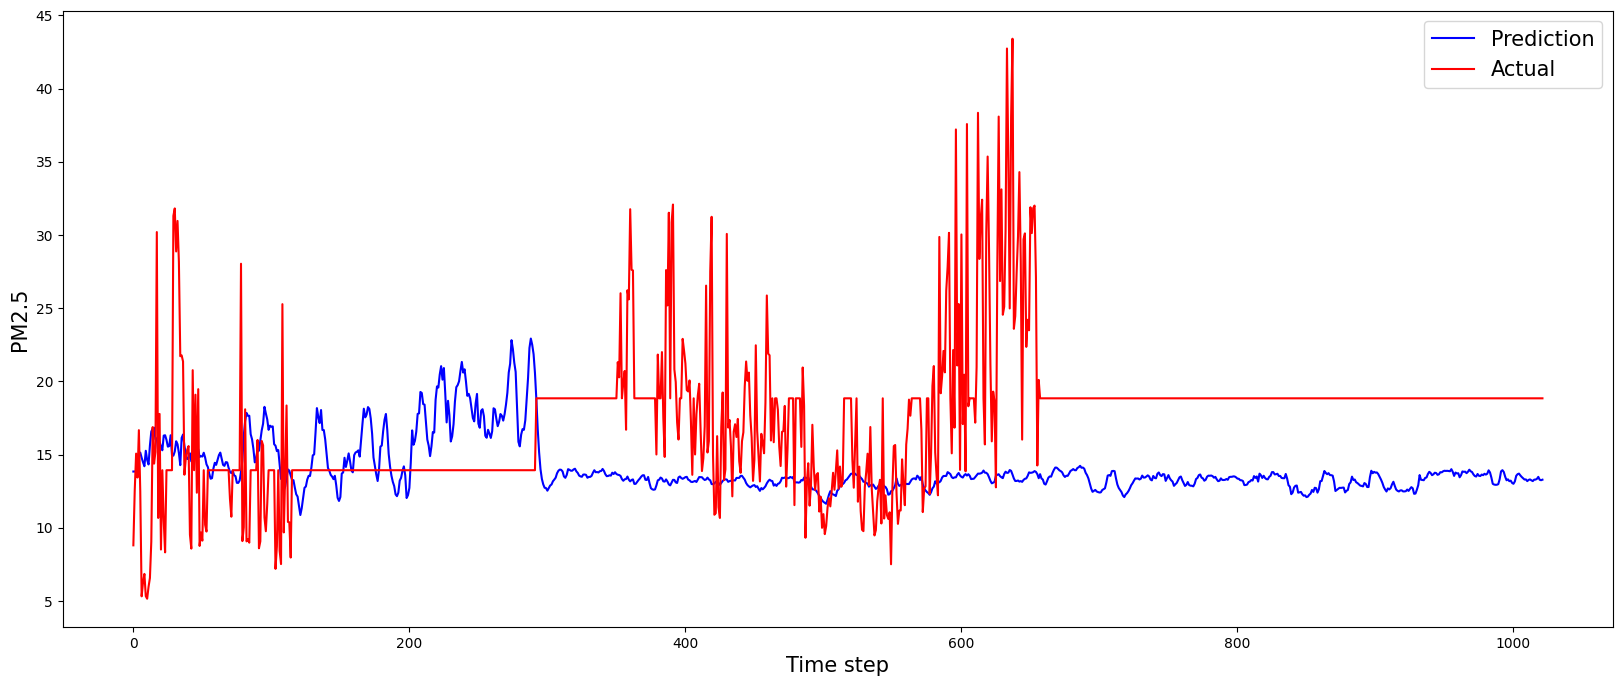

22129/22129 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
df_inference.shape = (708100, 3)


In [28]:
df_mpair_inference, mae, mse, r2 = predictLSTM(X_train=X_train_scaled,
            y_train=y_train_scaled,
            X_val=X_val_scaled,
            y_val=y_val_scaled,
            X_test=X_test_scaled,
            y_test=y_test_scaled,
            X_inference=X_inference_scaled)

evaluation_board['dim_reduction_method'].append("None")
evaluation_board['dim_after_reduction'].append("None")
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(mae)
evaluation_board['mse (test data)'].append(mse)
evaluation_board['r2 (test data)'].append(r2)

#### Compare with other locations

In [29]:
df_mpair_inference

,pm25,i,j
time,,,
2021-01-01,11.966890,0,3
2021-01-01,11.966890,0,3
2021-01-01,12.064099,0,3
2021-01-01,12.143359,0,3
2021-01-01,12.098188,0,3
...,...,...,...
2022-08-06,11.496346,34,27
2022-08-06,11.451700,34,27
2022-08-06,11.470668,34,27


In [30]:
list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None))

[(12, 22), (15, 14), (15, 18), (16, 16), (16, 17), (17, 17), (18, 14)]

In [31]:
location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
df_location_with_station

,i,j,station,pm25
time,,,,
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
...,...,...,...,...
2021-09-24,15,14,213.0,23.598236
2021-09-24,15,14,213.0,23.598236
2021-09-24,15,14,213.0,23.598236


In [32]:
df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
df_nearest_location

,pm25,i,j
time,,,
2021-09-24,12.177274,15,16
2021-09-24,12.135518,15,16
2021-09-24,12.161787,15,16
2021-09-24,12.237146,15,16
2021-09-24,12.217157,15,16
...,...,...,...
2021-09-25,12.240332,15,16
2021-09-25,12.262416,15,16
2021-09-25,12.228925,15,16


In [33]:
df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
df_random_location

,pm25,i,j
time,,,
2022-08-05,11.367110,34,27
2022-08-05,11.327868,34,27
2022-08-05,11.282305,34,27
2022-08-05,11.210276,34,27
2022-08-05,11.327268,34,27
...,...,...,...
2022-08-06,11.496346,34,27
2022-08-06,11.451700,34,27
2022-08-06,11.470668,34,27


In [34]:
print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")

location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)
mae between location_with_station and random_location = 13.333752033900842
mae between location_with_station and nearest_location = 11.934276692833208


### Prediction with lstms2s encoder

#### Encode data

In [35]:
lstms2s_encoder = list(filter(lambda model: ("aod_lstms2s" in model) & ("no_pm25_3km" in model) , glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(lstms2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(lstms2s_encoder)
print(encoder_model.summary())

# Encode train data
print(f"X_train_scaled.shape = {X_train_scaled.shape}")
X_train_scaled_padded = np.vstack((np.tile(X_train_scaled[0], (n_past, 1)),
                                    X_train_scaled,
                                    np.tile(X_train_scaled[-1], (n_future-1, 1))))
print(f"X_train_scaled_padded.shape = {X_train_scaled_padded.shape}")
X_train_scaled_reframed, _ = reframe_past_future(X_train_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_train_scaled_reframed.shape = {X_train_scaled_reframed.shape}")
X_train_scaled_lstms2s_encoded = encoder_model.predict(X_train_scaled_reframed)
print(f"X_train_scaled_lstms2s_encoded.shape = {X_train_scaled_lstms2s_encoded.shape}")
print("=" * 100)

# Encode validation data
print(f"X_val_scaled.shape = {X_val_scaled.shape}")
X_val_scaled_padded = np.vstack((np.tile(X_val_scaled[0], (n_past, 1)),
                                 X_val_scaled,
                                np.tile(X_val_scaled[-1], (n_future-1, 1))))
print(f"X_val_scaled_padded.shape = {X_val_scaled_padded.shape}")
X_val_scaled_reframed, _ = reframe_past_future(X_val_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_val_scaled_reframed.shape = {X_val_scaled_reframed.shape}")
X_val_scaled_lstms2s_encoded = encoder_model.predict(X_val_scaled_reframed)
print(f"X_val_scaled_lstms2s_encoded.shape = {X_val_scaled_lstms2s_encoded.shape}")
print("=" * 100)

# Encode test data
print(f"X_test_scaled.shape = {X_test_scaled.shape}")
X_test_scaled_padded = np.vstack((np.tile(X_test_scaled[0], (n_past, 1)),
                                 X_test_scaled,
                                np.tile(X_test_scaled[-1], (n_future-1, 1))))
print(f"X_test_scaled_padded.shape = {X_test_scaled_padded.shape}")
X_test_scaled_reframed, _ = reframe_past_future(X_test_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_test_scaled_reframed.shape = {X_test_scaled_reframed.shape}")
X_test_scaled_lstms2s_encoded = encoder_model.predict(X_test_scaled_reframed)
print(f"X_test_scaled_lstms2s_encoded.shape = {X_test_scaled_lstms2s_encoded.shape}")
print("=" * 100)

# Encode inference data
print(f"X_inference_scaled.shape = {X_inference_scaled.shape}")
X_inference_scaled_padded = np.vstack((np.tile(X_inference_scaled[0], (n_past, 1)),
                                 X_inference_scaled,
                                np.tile(X_inference_scaled[-1], (n_future-1, 1))))
print(f"X_inference_scaled_padded.shape = {X_inference_scaled_padded.shape}")
X_inference_scaled_reframed, _ = reframe_past_future(X_inference_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_inference_scaled_reframed.shape = {X_inference_scaled_reframed.shape}")
X_inference_scaled_lstms2s_encoded = encoder_model.predict(X_inference_scaled_reframed)
print(f"X_inference_scaled_lstms2s_encoded.shape = {X_inference_scaled_lstms2s_encoded.shape}")

/le_thanh_van_118/workspace/hiep_workspace/best_reduction_models/aod_lstms2s_dim_reduction_15_features_no_pm25_3km_encoder.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "aod_lstms2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,697 (920.70 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,132 (613.80 KB)

None
X_train_scaled.shape = (3270, 18)
X_train_scaled_padded.shape = (3283, 18)
X_train_scaled_reframed.shape = (3270, 7, 18)
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
X_train_scaled_lstms2s_encoded.shape = (3270, 15)
X_val_scaled.shape = (818, 18)
X_val_scaled_padded.shape = (831, 18)
X_val_scaled_reframed.shape = (818, 7, 18)
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
X_val_scaled_lstms2s_encoded.shape = (818, 15)
X_test_scaled.shape = (1022, 18)
X_test_scaled_padded.shape = (1035, 18)
X_test_scaled_reframed.shape = (1022, 7, 18)
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
X_test_scaled_lstms2s_encoded.shape = (1022, 15)
X_inference_scaled.shape = (708100, 18)
X_inference_scaled_padded.shape = (708113, 18)
X_inference_scaled_reframed.shape = (708100, 7, 18)
22129/22129 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step
X_inference_scaled_lstms2s_encoded.shape = (708100, 15)


#### LSTM prediction

X_train.shape = (3270, 15)
y_train.shape = (3270, 1)
X_train_reframed.shape = (3263, 7, 15)
y_train_reframed.shape = (3263, 1)
X_val.shape = (818, 15)
y_val.shape = (818, 1)
X_val_reframed.shape = (811, 7, 15)
y_val_reframed.shape = (811, 1)
X_test.shape = (1022, 15)
y_test.shape = (1022, 1)
X_test_padded.shape = (1029, 15)
y_test_padded.shape = (1029, 1)
X_test_reframed.shape = (1022, 7, 15)
y_test_reframed.shape = (1022, 1)
X_inference.shape = (708100, 15)
X_inference_padded.shape = (708107, 15)
X_inference_refamed.shape = (708100, 7, 15)
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0072 - val_loss: 0.0175
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0201 - val_loss: 0.0128
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0031 - val_loss: 0.0132
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0124
Epoch 6/200
26/26 ━━━━━━━

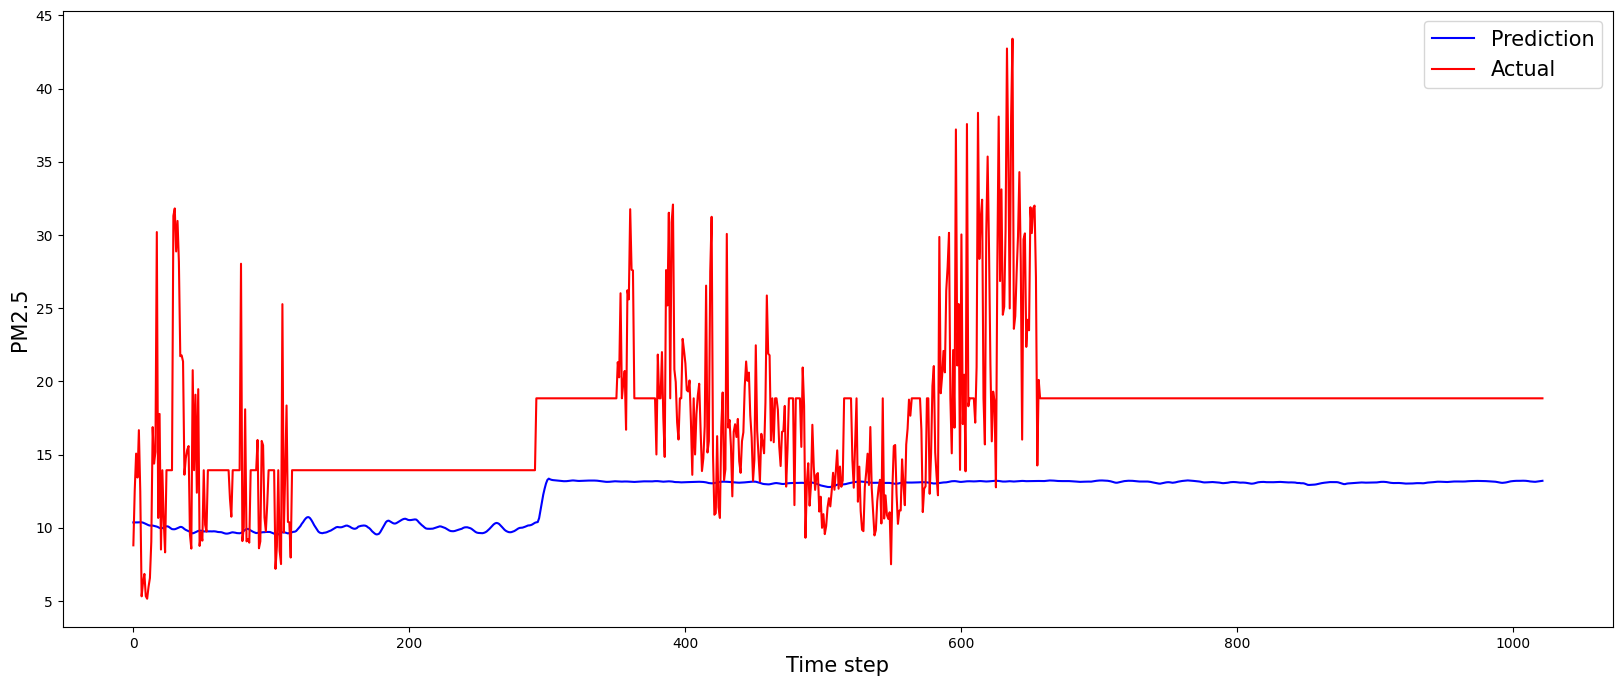

22129/22129 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
df_inference.shape = (708100, 3)


In [36]:
df_mpair_inference, mae, mse, r2 = predictLSTM(X_train=X_train_scaled_lstms2s_encoded,
            y_train=y_train_scaled,
            X_val=X_val_scaled_lstms2s_encoded,
            y_val=y_val_scaled,
            X_test=X_test_scaled_lstms2s_encoded,
            y_test=y_test_scaled,
            X_inference=X_inference_scaled_lstms2s_encoded)

evaluation_board['dim_reduction_method'].append("LSTM-Seq2Seq")
evaluation_board['dim_after_reduction'].append(X_train_scaled_lstms2s_encoded.shape[-1])
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(mae)
evaluation_board['mse (test data)'].append(mse)
evaluation_board['r2 (test data)'].append(r2)

#### Compare with other locations

In [37]:
df_mpair_inference

,pm25,i,j
time,,,
2021-01-01,12.492560,0,3
2021-01-01,12.492560,0,3
2021-01-01,12.492560,0,3
2021-01-01,12.494033,0,3
2021-01-01,12.497217,0,3
...,...,...,...
2022-08-06,12.349376,34,27
2022-08-06,12.417111,34,27
2022-08-06,12.505855,34,27


In [38]:
list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None))

[(12, 22), (15, 14), (15, 18), (16, 16), (16, 17), (17, 17), (18, 14)]

In [39]:
location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
df_location_with_station

,i,j,station,pm25
time,,,,
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
...,...,...,...,...
2021-09-24,15,14,213.0,23.598236
2021-09-24,15,14,213.0,23.598236
2021-09-24,15,14,213.0,23.598236


In [40]:
df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
df_nearest_location

,pm25,i,j
time,,,
2021-09-24,13.479354,15,16
2021-09-24,13.502459,15,16
2021-09-24,13.504727,15,16
2021-09-24,13.497182,15,16
2021-09-24,13.494083,15,16
...,...,...,...
2021-09-25,13.270210,15,16
2021-09-25,13.306402,15,16
2021-09-25,13.360909,15,16


In [41]:
df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
df_random_location

,pm25,i,j
time,,,
2022-08-05,12.683510,34,27
2022-08-05,12.697206,34,27
2022-08-05,12.702946,34,27
2022-08-05,12.700346,34,27
2022-08-05,12.685431,34,27
...,...,...,...
2022-08-06,12.349376,34,27
2022-08-06,12.417111,34,27
2022-08-06,12.505855,34,27


In [42]:
print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")

location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)
mae between location_with_station and random_location = 11.210380408597839
mae between location_with_station and nearest_location = 11.06512184393471


### Prediction with grus2s encoder

#### Encode data

In [43]:
grus2s_encoder = list(filter(lambda model: ("aod_grus2s" in model) & ("no_pm25_3km" in model) , glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(grus2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(grus2s_encoder)
print(encoder_model.summary())

# Encode train data
print(f"X_train_scaled.shape = {X_train_scaled.shape}")
X_train_scaled_padded = np.vstack((np.tile(X_train_scaled[0], (n_past, 1)),
                                    X_train_scaled,
                                    np.tile(X_train_scaled[-1], (n_future-1, 1))))
print(f"X_train_scaled_padded.shape = {X_train_scaled_padded.shape}")
X_train_scaled_reframed, _ = reframe_past_future(X_train_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_train_scaled_reframed.shape = {X_train_scaled_reframed.shape}")
X_train_scaled_grus2s_encoded = encoder_model.predict(X_train_scaled_reframed)
print(f"X_train_scaled_grus2s_encoded.shape = {X_train_scaled_grus2s_encoded.shape}")
print("=" * 100)

# Encode validation data
print(f"X_val_scaled.shape = {X_val_scaled.shape}")
X_val_scaled_padded = np.vstack((np.tile(X_val_scaled[0], (n_past, 1)),
                                 X_val_scaled,
                                np.tile(X_val_scaled[-1], (n_future-1, 1))))
print(f"X_val_scaled_padded.shape = {X_val_scaled_padded.shape}")
X_val_scaled_reframed, _ = reframe_past_future(X_val_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_val_scaled_reframed.shape = {X_val_scaled_reframed.shape}")
X_val_scaled_grus2s_encoded = encoder_model.predict(X_val_scaled_reframed)
print(f"X_val_scaled_grus2s_encoded.shape = {X_val_scaled_grus2s_encoded.shape}")
print("=" * 100)

# Encode test data
print(f"X_test_scaled.shape = {X_test_scaled.shape}")
X_test_scaled_padded = np.vstack((np.tile(X_test_scaled[0], (n_past, 1)),
                                 X_test_scaled,
                                np.tile(X_test_scaled[-1], (n_future-1, 1))))
print(f"X_test_scaled_padded.shape = {X_test_scaled_padded.shape}")
X_test_scaled_reframed, _ = reframe_past_future(X_test_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_test_scaled_reframed.shape = {X_test_scaled_reframed.shape}")
X_test_scaled_grus2s_encoded = encoder_model.predict(X_test_scaled_reframed)
print(f"X_test_scaled_grus2s_encoded.shape = {X_test_scaled_grus2s_encoded.shape}")
print("=" * 100)

# Encode inference data
print(f"X_inference_scaled.shape = {X_inference_scaled.shape}")
X_inference_scaled_padded = np.vstack((np.tile(X_inference_scaled[0], (n_past, 1)),
                                 X_inference_scaled,
                                np.tile(X_inference_scaled[-1], (n_future-1, 1))))
print(f"X_inference_scaled_padded.shape = {X_inference_scaled_padded.shape}")
X_inference_scaled_reframed, _ = reframe_past_future(X_inference_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_inference_scaled_reframed.shape = {X_inference_scaled_reframed.shape}")
X_inference_scaled_grus2s_encoded = encoder_model.predict(X_inference_scaled_reframed)
print(f"X_inference_scaled_grus2s_encoded.shape = {X_inference_scaled_grus2s_encoded.shape}")

/le_thanh_van_118/workspace/hiep_workspace/best_reduction_models/aod_grus2s_dim_reduction_17_features_no_pm25_3km_encoder.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "aod_grus2s_dim_reduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,003 (699.23 KB)

 Trainable params: 59,667 (233.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 119,336 (466.16 KB)

None
X_train_scaled.shape = (3270, 18)
X_train_scaled_padded.shape = (3283, 18)
X_train_scaled_reframed.shape = (3270, 7, 18)
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
X_train_scaled_grus2s_encoded.shape = (3270, 17)
X_val_scaled.shape = (818, 18)
X_val_scaled_padded.shape = (831, 18)
X_val_scaled_reframed.shape = (818, 7, 18)
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
X_val_scaled_grus2s_encoded.shape = (818, 17)
X_test_scaled.shape = (1022, 18)
X_test_scaled_padded.shape = (1035, 18)
X_test_scaled_reframed.shape = (1022, 7, 18)
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
X_test_scaled_grus2s_encoded.shape = (1022, 17)
X_inference_scaled.shape = (708100, 18)
X_inference_scaled_padded.shape = (708113, 18)
X_inference_scaled_reframed.shape = (708100, 7, 18)
22129/22129 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step
X_inference_scaled_grus2s_encoded.shape = (708100, 17)


#### LSTM prediction

X_train.shape = (3270, 17)
y_train.shape = (3270, 1)
X_train_reframed.shape = (3263, 7, 17)
y_train_reframed.shape = (3263, 1)
X_val.shape = (818, 17)
y_val.shape = (818, 1)
X_val_reframed.shape = (811, 7, 17)
y_val_reframed.shape = (811, 1)
X_test.shape = (1022, 17)
y_test.shape = (1022, 1)
X_test_padded.shape = (1029, 17)
y_test_padded.shape = (1029, 1)
X_test_reframed.shape = (1022, 7, 17)
y_test_reframed.shape = (1022, 1)
X_inference.shape = (708100, 17)
X_inference_padded.shape = (708107, 17)
X_inference_refamed.shape = (708100, 7, 17)
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0085
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0087
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0089
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 6/200
26/26 ━━━━━━━━

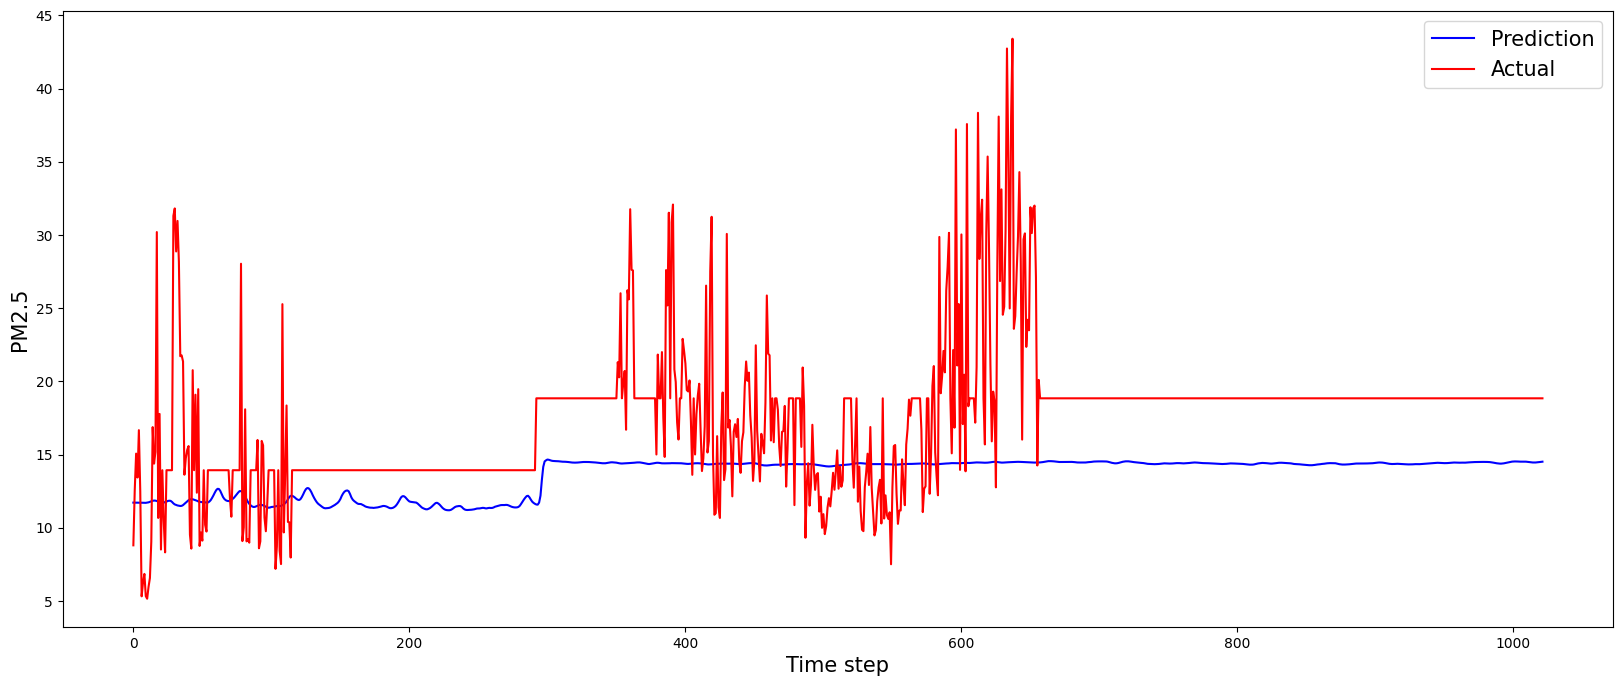

22129/22129 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
df_inference.shape = (708100, 3)


In [44]:
df_mpair_inference, mae, mse, r2 = predictLSTM(X_train=X_train_scaled_grus2s_encoded,
            y_train=y_train_scaled,
            X_val=X_val_scaled_grus2s_encoded,
            y_val=y_val_scaled,
            X_test=X_test_scaled_grus2s_encoded,
            y_test=y_test_scaled,
            X_inference=X_inference_scaled_grus2s_encoded)

evaluation_board['dim_reduction_method'].append("GRU-Seq2Seq")
evaluation_board['dim_after_reduction'].append(X_train_scaled_grus2s_encoded.shape[-1])
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(mae)
evaluation_board['mse (test data)'].append(mse)
evaluation_board['r2 (test data)'].append(r2)

#### Compare with other locations

In [45]:
df_mpair_inference

,pm25,i,j
time,,,
2021-01-01,14.980663,0,3
2021-01-01,14.980663,0,3
2021-01-01,14.980663,0,3
2021-01-01,14.980366,0,3
2021-01-01,14.982721,0,3
...,...,...,...
2022-08-06,14.835884,34,27
2022-08-06,14.833034,34,27
2022-08-06,14.829689,34,27


In [46]:
list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None))

[(12, 22), (15, 14), (15, 18), (16, 16), (16, 17), (17, 17), (18, 14)]

In [47]:
location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
df_location_with_station

,i,j,station,pm25
time,,,,
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
...,...,...,...,...
2021-09-24,15,14,213.0,23.598236
2021-09-24,15,14,213.0,23.598236
2021-09-24,15,14,213.0,23.598236


In [48]:
df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
df_nearest_location

,pm25,i,j
time,,,
2021-09-24,14.935759,15,16
2021-09-24,14.936067,15,16
2021-09-24,14.919803,15,16
2021-09-24,14.872872,15,16
2021-09-24,14.789633,15,16
...,...,...,...
2021-09-25,12.844357,15,16
2021-09-25,12.764812,15,16
2021-09-25,12.682891,15,16


In [49]:
df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
df_random_location

,pm25,i,j
time,,,
2022-08-05,14.851090,34,27
2022-08-05,14.853531,34,27
2022-08-05,14.854166,34,27
2022-08-05,14.852354,34,27
2022-08-05,14.849916,34,27
...,...,...,...
2022-08-06,14.835884,34,27
2022-08-06,14.833034,34,27
2022-08-06,14.829689,34,27


In [50]:
print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")

location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)
mae between location_with_station and random_location = 9.26627355296552
mae between location_with_station and nearest_location = 11.467449290647366


### Prediction with cnnlstms2s encoder

#### Encode data

In [51]:
cnnlstms2s_encoder = list(filter(lambda model: ("aod_cnnlstms2s" in model) & ("no_pm25_3km" in model) , glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(cnnlstms2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(cnnlstms2s_encoder)
print(encoder_model.summary())

# Encode train data
print(f"X_train_scaled.shape = {X_train_scaled.shape}")
X_train_scaled_padded = np.vstack((np.tile(X_train_scaled[0], (n_past, 1)),
                                    X_train_scaled,
                                    np.tile(X_train_scaled[-1], (n_future-1, 1))))
print(f"X_train_scaled_padded.shape = {X_train_scaled_padded.shape}")
X_train_scaled_reframed, _ = reframe_past_future(X_train_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_train_scaled_reframed.shape = {X_train_scaled_reframed.shape}")
X_train_scaled_cnnlstms2s_encoded = encoder_model.predict(X_train_scaled_reframed)
print(f"X_train_scaled_cnnlstms2s_encoded.shape = {X_train_scaled_cnnlstms2s_encoded.shape}")
print("=" * 100)

# Encode validation data
print(f"X_val_scaled.shape = {X_val_scaled.shape}")
X_val_scaled_padded = np.vstack((np.tile(X_val_scaled[0], (n_past, 1)),
                                 X_val_scaled,
                                np.tile(X_val_scaled[-1], (n_future-1, 1))))
print(f"X_val_scaled_padded.shape = {X_val_scaled_padded.shape}")
X_val_scaled_reframed, _ = reframe_past_future(X_val_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_val_scaled_reframed.shape = {X_val_scaled_reframed.shape}")
X_val_scaled_cnnlstms2s_encoded = encoder_model.predict(X_val_scaled_reframed)
print(f"X_val_scaled_cnnlstms2s_encoded.shape = {X_val_scaled_cnnlstms2s_encoded.shape}")
print("=" * 100)

# Encode test data
print(f"X_test_scaled.shape = {X_test_scaled.shape}")
X_test_scaled_padded = np.vstack((np.tile(X_test_scaled[0], (n_past, 1)),
                                 X_test_scaled,
                                np.tile(X_test_scaled[-1], (n_future-1, 1))))
print(f"X_test_scaled_padded.shape = {X_test_scaled_padded.shape}")
X_test_scaled_reframed, _ = reframe_past_future(X_test_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_test_scaled_reframed.shape = {X_test_scaled_reframed.shape}")
X_test_scaled_cnnlstms2s_encoded = encoder_model.predict(X_test_scaled_reframed)
print(f"X_test_scaled_cnnlstms2s_encoded.shape = {X_test_scaled_cnnlstms2s_encoded.shape}")
print("=" * 100)

# Encode inference data
print(f"X_inference_scaled.shape = {X_inference_scaled.shape}")
X_inference_scaled_padded = np.vstack((np.tile(X_inference_scaled[0], (n_past, 1)),
                                 X_inference_scaled,
                                np.tile(X_inference_scaled[-1], (n_future-1, 1))))
print(f"X_inference_scaled_padded.shape = {X_inference_scaled_padded.shape}")
X_inference_scaled_reframed, _ = reframe_past_future(X_inference_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_inference_scaled_reframed.shape = {X_inference_scaled_reframed.shape}")
X_inference_scaled_cnnlstms2s_encoded = encoder_model.predict(X_inference_scaled_reframed)
print(f"X_inference_scaled_cnnlstms2s_encoded.shape = {X_inference_scaled_cnnlstms2s_encoded.shape}")

/le_thanh_van_118/workspace/hiep_workspace/best_reduction_models/aod_cnnlstms2s_dim_reduction_15_features_no_pm25_3km_encoder.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "aod_cnnlstms2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_40 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,685 (182.37 KB)

 Trainable params: 15,561 (60.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,124 (121.58 KB)

None
X_train_scaled.shape = (3270, 18)
X_train_scaled_padded.shape = (3283, 18)
X_train_scaled_reframed.shape = (3270, 7, 18)
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
X_train_scaled_cnnlstms2s_encoded.shape = (3270, 15)
X_val_scaled.shape = (818, 18)
X_val_scaled_padded.shape = (831, 18)
X_val_scaled_reframed.shape = (818, 7, 18)
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
X_val_scaled_cnnlstms2s_encoded.shape = (818, 15)
X_test_scaled.shape = (1022, 18)
X_test_scaled_padded.shape = (1035, 18)
X_test_scaled_reframed.shape = (1022, 7, 18)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
X_test_scaled_cnnlstms2s_encoded.shape = (1022, 15)
X_inference_scaled.shape = (708100, 18)
X_inference_scaled_padded.shape = (708113, 18)
X_inference_scaled_reframed.shape = (708100, 7, 18)
22129/22129 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
X_inference_scaled_cnnlstms2s_encoded.shape = (708100, 15)


#### LSTM prediction

X_train.shape = (3270, 15)
y_train.shape = (3270, 1)
X_train_reframed.shape = (3263, 7, 15)
y_train_reframed.shape = (3263, 1)
X_val.shape = (818, 15)
y_val.shape = (818, 1)
X_val_reframed.shape = (811, 7, 15)
y_val_reframed.shape = (811, 1)
X_test.shape = (1022, 15)
y_test.shape = (1022, 1)
X_test_padded.shape = (1029, 15)
y_test_padded.shape = (1029, 1)
X_test_reframed.shape = (1022, 7, 15)
y_test_reframed.shape = (1022, 1)
X_inference.shape = (708100, 15)
X_inference_padded.shape = (708107, 15)
X_inference_refamed.shape = (708100, 7, 15)
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0062 - val_loss: 0.0117
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - val_loss: 0.0115
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - val_loss: 0.0109
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - val_loss: 0.0108
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0109
Epoch 6/200
26/26 ━━━━━━━━

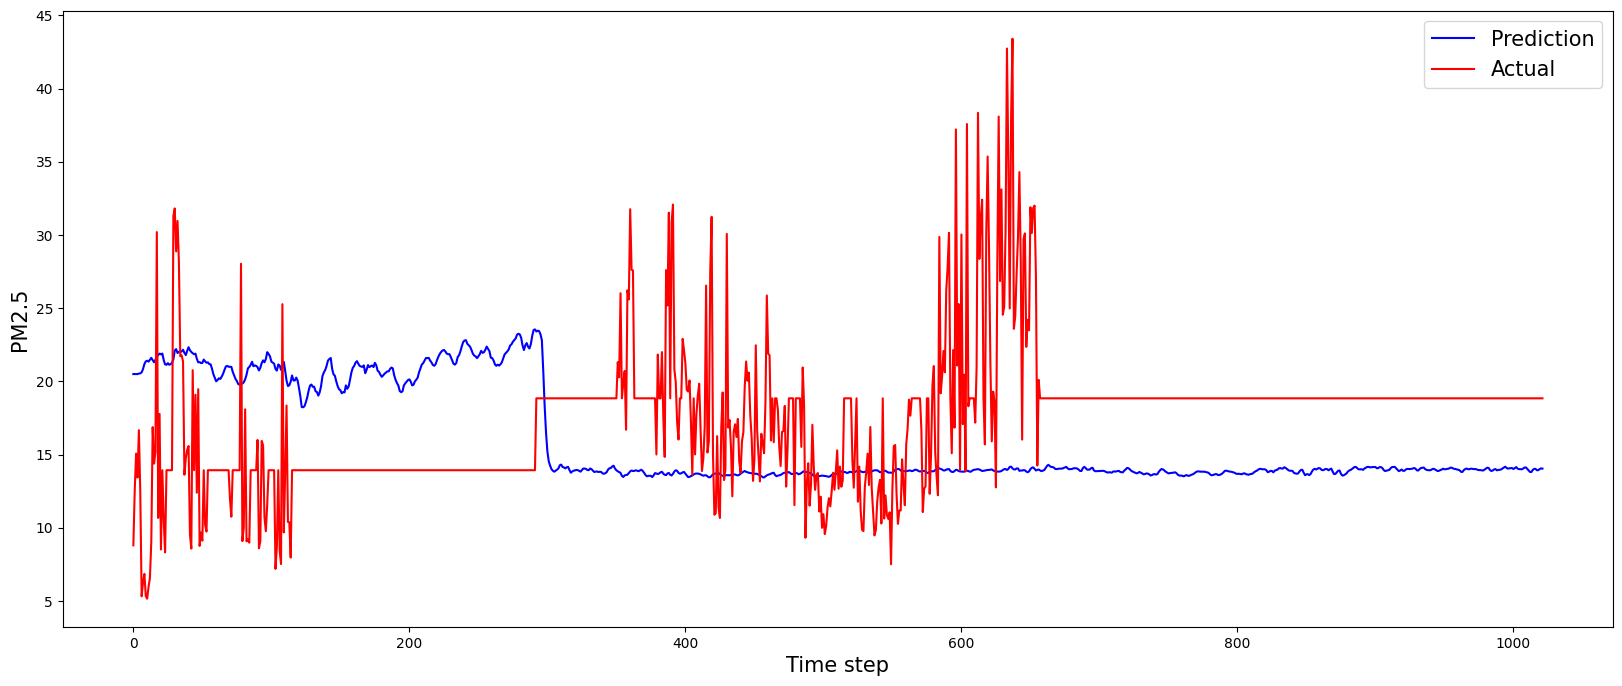

22129/22129 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step
df_inference.shape = (708100, 3)


In [52]:
df_mpair_inference, mae, mse, r2 = predictLSTM(X_train=X_train_scaled_cnnlstms2s_encoded,
            y_train=y_train_scaled,
            X_val=X_val_scaled_cnnlstms2s_encoded,
            y_val=y_val_scaled,
            X_test=X_test_scaled_cnnlstms2s_encoded,
            y_test=y_test_scaled,
            X_inference=X_inference_scaled_cnnlstms2s_encoded)

evaluation_board['dim_reduction_method'].append("CNN-LSTM-Seq2Seq")
evaluation_board['dim_after_reduction'].append(X_train_scaled_cnnlstms2s_encoded.shape[-1])
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(mae)
evaluation_board['mse (test data)'].append(mse)
evaluation_board['r2 (test data)'].append(r2)

#### Compare with other locations

In [53]:
df_mpair_inference

,pm25,i,j
time,,,
2021-01-01,14.497477,0,3
2021-01-01,14.497477,0,3
2021-01-01,14.497477,0,3
2021-01-01,14.497477,0,3
2021-01-01,14.503005,0,3
...,...,...,...
2022-08-06,13.628954,34,27
2022-08-06,13.610008,34,27
2022-08-06,13.571254,34,27


In [54]:
list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None))

[(12, 22), (15, 14), (15, 18), (16, 16), (16, 17), (17, 17), (18, 14)]

In [55]:
location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
df_location_with_station

,i,j,station,pm25
time,,,,
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
2021-09-23,15,14,213.0,23.598236
...,...,...,...,...
2021-09-24,15,14,213.0,23.598236
2021-09-24,15,14,213.0,23.598236
2021-09-24,15,14,213.0,23.598236


In [56]:
df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
df_nearest_location

,pm25,i,j
time,,,
2021-09-24,13.191168,15,16
2021-09-24,13.286808,15,16
2021-09-24,13.340570,15,16
2021-09-24,13.284786,15,16
2021-09-24,13.154527,15,16
...,...,...,...
2021-09-25,11.942245,15,16
2021-09-25,12.007879,15,16
2021-09-25,12.047239,15,16


In [57]:
df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
df_random_location

,pm25,i,j
time,,,
2022-08-05,13.542824,34,27
2022-08-05,13.534112,34,27
2022-08-05,13.551817,34,27
2022-08-05,13.572468,34,27
2022-08-05,13.568602,34,27
...,...,...,...
2022-08-06,13.628954,34,27
2022-08-06,13.610008,34,27
2022-08-06,13.571254,34,27


In [58]:
print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")

location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)
mae between location_with_station and random_location = 10.337366793630332
mae between location_with_station and nearest_location = 12.089944026218328


## Result

In [59]:
pd.DataFrame(evaluation_board)

,dim_reduction_method,dim_after_reduction,prediction_method,mae (test data),mse (test data),r2 (test data)
0,None,None,LSTM,5.124862,40.388074,-0.913742
1,LSTM-Seq2Seq,15,LSTM,5.494906,43.899318,-1.080118
2,GRU-Seq2Seq,17,LSTM,4.380831,31.525709,-0.493809
3,CNN-LSTM-Seq2Seq,15,LSTM,5.982451,48.336424,-1.290365
